# Binary Black Hole Evolution: Stable Mass Transfer vs Common Envelope
**Group 3 authors:** 
- Bonasera Elias Maria (2149751)
- Casellato Alberto (2139206)
- Garbin Nicola (2156363)
- Tamanna Tasneem (2040474)


## 1. Goal of the Project

The goal of our project is, given a set of simulated binary black hole (BBH) systems, to understand how the physical properties of the systems are correlated with their evolutionary path (Stable Mass Transfer or Common Envelope). 

Our task is divided into two parts:

- Classify the BBHs based on their evolutionary track 
- Analyze how different physical parameters affect the evolution of BBH

To perform this, we will use visualization techniques and machine learning methods (e.g. Random Forest) to determine the most significant features that influence BBH evolution.

## 2. Theoretical Background

A **binary star system** is composed of two stars that orbit around the center of mass of the system. The most massive star is called the **primary star** (or *donor star*), and the other one is the **secondary star** (or *accretor*). There are different ways in which a star can lose mass; the most common are:

- **Stellar winds**: which occours because of single star evolution. This mass loss follows the relation $\dot{M} \propto Z^p$, with $p$ a coefficient that depends on the star's temperature.
- **Roche Lobe overflow**: which happens when a star increases in size due to natural evolution, exceeding a certain boundary. This boundary is defined by two teardrop-shaped equipotential surfaces that connect the two stars, within which the stars are confined. Each teardrop is called the **Roche Lobe** of a star, and the point where they meet is the **Lagrangian point L1**. When stellar matter reaches L1, it is no longer gravitationally bound to the donor star and is transferred to the accretor, starting a process of mass transfer known as **Roche Lobe overflow**.

### 2.1 Roche Lobe Overflow
The donor star has the biggest Roche lobe, but it is the first one to fill it because the more a star is massive and the faster is its evolution.\
From the literature, we get that $R_L \propto a \ f(q)$, where:
- $R_L$ is the Roche Lobe radius,
- $a$ is the semi-major axis of the system,
- $q$ is the mass ratio of the two stars.

<img src="images/roche_potential.png" width="400">

There are two types of responses a star can have to mass loss, depending on its internal structure:

- **Stable Mass Transfer (SMT)**: The star responds to mass loss by adjusting its size, leading to a gradual transfer of mass to the secondary star. This results in minimal mass loss from the system.
- **Common Envelope (CE)**: The primary star expands uncontrollably, leading to an unstable phase where the outer layers engulf both stars, forming a common envelope.

### 2.2 Common Envelope
The common envelope that surrounds the two stars extends beyond the system's orbit. Due to angular momentum conservation, it rotates slower than the two stars inside. This difference in velocity creates friction forces, which extract energy from the system, causing the two stars to spiral inward.

There are two possible outcomes:
- The system transfers enough energy to the common envelope to eject it outward, leaving behind a shrunken orbit and a significant mass loss.
- The system fails to transfer enough energy, leading to the merging of both stars inside the envelope, forming a single object surrounded by the ejected material.

The **$\alpha$ parameter** is a free parameter that quantifies the efficiency of energy transfer between the system and the common envelope. It determines how much orbital energy is used to eject the envelope: the larger it is, the lesser orbital energy is required.

<img src="images/common_envelope_evolution.png" width="400">


<!--
Da aggiungere alle conclusioni:
- CE processo più dissipativo, infatti crea buchi neri di massa più piccola, mentre SMT crea BH più massicci
-->


## 3. Datasets

Data is contained in the folder `data`, which contains four folders, one for each value of $\alpha$ (0.5, 1, 3, 5): *A05*, *A1*, *A3* and *A5*. Inside every folder, there are 12 files named MTCE_BBHs_*.txt, where \* is a number that represents the metallicity, from 0.0002 to 0.02. Each file follows this structure:

### Header
- `Row 0`: Header for Row 1 
- `Row 1`: Two columns:  
  - `Column 0`: Total mass of the simulated systems ($M_{\odot}$) 
  - `Column 1`: Number of binary black hole mergers
- `Row 2`: Header for the data columns
  
### Main dataset
- **Systems ID:**
    - `Column 0`: Identifier of the binary system

- **Individual Star Properties:**
    - `Column 1`: Initial mass (ZAMS: Zero Age Main Sequence) of the primary star ($M_{\odot}$)
    - `Column 2`: Initial mass (ZAMS) of the secondary star ($M_{\odot}$)
    - `Column 3`: Mass of the black hole formed from the primary star ($M_{\odot}$)
    - `Column 4`: Mass of the black hole formed from the secondary star ($M_{\odot}$)

- **Binary System Properties:**
    - `Column 5`: Total Mass of the BBH system ($M_{\odot}$)
    - `Column 6`: Delay time (time from the formation of the binary system to the merger of the two BHs, in Myr)
    - `Column 7`: Semi-major axis of the binary at the formation of the second black hole ($R_{\odot}$)
    - `Column 8`: Orbital eccentricity of the system at the formation of the second black hole

- **Supernova Properties:**
    - `Column 9`: Magnitude of the supernova kick (km/s) for the primary black hole
    - `Column 10`: Magnitude of the supernova kick (km/s) for the secondary black hole
    - `Column 11`: Cosine of the tilt angle (before and after supernova) for the primary black hole
    - `Column 12`: Cosine of the tilt angle (before and after supernova) for the secondary black hole
    - `Columns 13-18`: x, y, z components of the center-of-mass velocity after the supernova explosion of the primary and secondary components
    - `Column 19`: Time at which the primary component undergoes a supernova
    - `Column 20`: Time at which the secondary component undergoes a supernova

- **Binary Classification Label:**
    - `Column 21`: Binary evolution path
        - `True`: The system evolved via common envelope
        - `False`: The system evolved via stable mass transfer

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd
import os

import pickle                                          # For saving and reading python3 objects

from sklearn import datasets
from sklearn.model_selection import train_test_split   # For splitting dataframe in (x, y)_train and (x, y)_test
from sklearn.preprocessing import StandardScaler       # For re-scale data (subtract average, divide by standard deviation)
from sklearn.ensemble import RandomForestClassifier    # The Random Forest Model
from sklearn.metrics import confusion_matrix           # To evaluate the predict power of the model
from sklearn.svm import SVC                            # The Support Vector Machines Model

from IPython.display import Image

## 4. Data Preprocessing and Data Visualization

### 4.1 Importing Data
We defined the function *load_data* to load the datasets as a nested dictionary, where the first keys correspond to $\alpha$ values, and the second ones are the different metallicities, with pandas dataframes as values.

Given as input a folder containing data, it first searches through every subdirectory of that folder, each representing a different $\alpha$ value, and then it reads the data files contained inside, corresponding to a different metallicity.

In this way, we can access data for a specific $\alpha$ and $Z$ as follows `data[alpha][metallicity]`.

In [2]:
def load_data(folder):
    dict_dataset = {}
    for filename1 in os.listdir(folder):
        folder_path = os.path.join(folder, filename1)
        list_dataset = {}

        for filename2 in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename2)
            df = pd.read_csv(file_path, delimiter=" ", skiprows=2)
            list_dataset[filename2.split("_")[2].split(".txt")[0]] = df
        
        dict_dataset[filename1] = list_dataset
    
    return dict_dataset

In [3]:
# plot settings
major_ticks_length = 10
minor_ticks_length = major_ticks_length / 2
label_size = 20
mpl.rcParams['axes.linewidth'] = 1.1

# loading data
data = load_data("data")

### 4.2 Visualizing Data

#### How the `plot_histogram` function works

- The function takes as input a list of two axes, two datasets, a list of metallicities, the number of bins, a limit for the x-axis, a label and a title. 
- It assigns a color to each metallicity with the plasma colormap. 
- If a limit for the x-axis is given, it determines also the histogram bins. Otherwise, the function uses the predefined binning. 
- The function plots on the first axis histograms for every metallicity of SMT systems and on the second axis  it does the same for CE systems.
- On the y-axis a logarythmic scale is applied, since the distributions cover a wide range of orders of magnitude.


#### How the `plot_stackplot` function works

- The function takes as input a dictionary containing the fractions of systems for different $\alpha$ values, a list of metallicities, and a color palette.
- The function generates a figure with four stackplots. Each plot corresponds to a different value of the $\alpha$ parameter and shows the fraction of SMT systems and CE systems, indicated with different colors, as a function of metallicity.
- It applies a logarithmic scale on the x-axis, where metallicities are represented.

In [4]:
def plot_histogram(axes, data_1, data_2, metallicities, bins=100, xlim=None, xlabel="", title=""):
    """
    Plots histograms for two sets of data with the same bins and xlim.
    """ 
    cmap = cm.plasma
    colors = [cmap(i / len(data_1)) for i in range(len(data_1))]
    if xlim:
        bins = np.linspace(xlim[0], xlim[1], bins)
    
    # plots
    for i in range(len(data_1)):
        for k,data in enumerate([data_1, data_2]):
            axes[k].hist(data[i], bins=bins, histtype="step", label=f"Z={metallicities[i]}", 
                         edgecolor=colors[i], linewidth=2)
    
    # axes settings
    axes[0].tick_params(axis='both', which='both', direction="in", top=True, right=True, labelbottom=False)
    axes[1].tick_params(axis='both', which='both', direction="in", top=True, right=True, labelbottom=True)
    
    axes[1].set_xlabel(xlabel, fontsize=label_size)

    for ax in axes:
        if xlim:
            ax.set_xlim(xlim)
        ax.set_yscale("log")
        ax.tick_params(which="major", length=major_ticks_length, labelsize=label_size)
        ax.tick_params(which="minor", length=minor_ticks_length)

    plt.tight_layout()


def plot_stackplot(fractions_dict, metallicities, colors):
    """
    Plots a stackplot showing fractions of stable mass transfer and common envelope systems.
    """    
    fig, axes = plt.subplots(1, 4, figsize=(6*4, 8), sharex=True, sharey=True, 
                             gridspec_kw={"hspace": 0, "wspace": 0})
    
    sorted_alpha = sorted(list(fractions_dict.keys()), key=lambda x: float(x[1:]))
    
    for i,alpha in enumerate(sorted_alpha):
        axes[i].stackplot(
            metallicities,
            fractions_dict[alpha][0],
            fractions_dict[alpha][1],
            labels=["Stable Mass Transfer", "Common Envelope"],
            colors=colors,
            edgecolor="k",
            alpha=0.8
        )    
        axes[i].tick_params(which="major", direction="in", length=major_ticks_length, labelsize=label_size+2)
        axes[i].tick_params(which="minor", direction="in", length=minor_ticks_length)
        
        if i == 0:
            axes[i].legend(loc="upper right", fontsize=label_size)
            axes[i].set_ylabel("Fraction", fontsize=label_size+7, labelpad=20)

        axes[i].set_xlim(min(metallicities), max(metallicities))
        axes[i].set_ylim(0,1.)
        axes[i].set_xscale("log")
        axes[i].set_title(f"$\\alpha$ = {alpha[1:]}", fontsize=label_size+3)
        axes[i].grid(linestyle="--", which="both", linewidth=1, color="dimgrey")
        
    fig.supxlabel("Metallicity", fontsize=label_size+7, y=0.01)
    fig.suptitle("Fraction of Systems with SMT and CE", fontsize=label_size+10, y=1)
    
    plt.tight_layout()
    plt.savefig("images/stackplot.png", bbox_inches='tight')
    plt.close(fig)

#### Property Distributions  

To analyze the influence of the different physical properties on the evolution of BBH systems, we will visualize the distribution of specific properties for various values of $\alpha$, considering different metallicities and evolutionary pathways (SMT or CE). We will show different figures, each consisting of two rows and four columns. The first row represents systems that evolve through SMT and the second row corresponds to systems undergoing CE evolution. Each column corresponds to a different value of the $\alpha$ parameter. The histograms inside each plot show the distribution of a specific property for different values of metallicities.

In [5]:
properties_alpha = {}
fractions_alpha = {}
list_metallicites = []

alpha_sorted = sorted(data.keys(), key=lambda x: float(x[1:]))
for a in alpha_sorted:
    dict_df = data[a]
    alpha = float(a[1:])
    
    masses_smt = []
    masses_ce = []
    masses2_smt = []
    masses2_ce = []
    masses_sum_smt=[]
    masses_sum_ce=[]
    masses_rate_smt = []
    masses_rate_ce = []
    masses_BH_smt = []
    masses_BH_ce = []
    masses_rate_BH_smt = []
    masses_rate_BH_ce = []
    delay_time_smt = []
    delay_time_ce = []
    list_sma_smt =[]
    list_sma_ce = []
    list_e_smt =[]
    list_e_ce = []
    
    smt_fractions = []
    ce_fractions = []
    
    metallicities = sorted(dict_df.keys(), key=lambda x: float(x))
    list_metallicites = [float(m) for m in metallicities]
    for i,z in enumerate(metallicities):
        df = dict_df[z]
        
        # data selection
        df_smt = df[df["col.21:CE"]==0]
        df_ce = df[df["col.21:CE"]==1]
        smt_count = df_smt.shape[0]
        ce_count = df_ce.shape[0]
        total_count = smt_count + ce_count
        smt_fractions.append(smt_count/total_count)
        ce_fractions.append(ce_count/total_count)
        
        m1_smt = df_smt["col.1:m1ZAMS/Msun"]
        m1_ce = df_ce["col.1:m1ZAMS/Msun"]
        m2_smt = df_smt['col.2:m2ZAMS/Msun']
        m2_ce = df_ce['col.2:m2ZAMS/Msun']
        
        m1_BH_smt = df_smt["col.3:m1rem/Msun"]
        m1_BH_ce = df_ce["col.3:m1rem/Msun"]
        m2_BH_smt = df_smt['col.4:m2rem/Msun']
        m2_BH_ce = df_ce['col.4:m2rem/Msun']
        
        delay_smt = df_smt['col.6:delay_time/Myr']/1000
        delay_ce = df_ce['col.6:delay_time/Myr']/1000
        
        sma_smt = df_smt['col.7:sma/Rsun']
        sma_ce = df_ce['col.7:sma/Rsun']
        
        e_smt = df_smt['col.8:ecc']
        e_ce = df_ce['col.8:ecc']
        
        # mass data
        masses_smt.append(m1_smt)
        masses_ce.append(m1_ce)
        
        # mass 2 data
        masses2_smt.append(m2_smt)
        masses2_ce.append(m2_ce)
        
        # mass sum
        masses_sum_smt.append(m1_smt + m2_smt)
        masses_sum_ce.append(m1_ce + m2_ce)
        
        # mass rate data
        masses_rate_smt.append(m2_smt/m1_smt)
        masses_rate_ce.append(m2_ce/m1_ce)
        
        # mass BH data
        masses_BH_smt.append(m1_BH_smt)
        masses_BH_ce.append(m1_BH_ce)
        
        # mass rate BH data
        masses_rate_BH_smt.append(m2_BH_smt/m1_BH_smt)
        masses_rate_BH_ce.append(m2_BH_ce/m1_BH_ce)
        
        # delay time data
        delay_time_smt.append(delay_smt)
        delay_time_ce.append(delay_ce)
        
        # semi-major axis data
        list_sma_smt.append(sma_smt)
        list_sma_ce.append(sma_ce)
        
        # eccentricity data
        list_e_smt.append(e_smt)
        list_e_ce.append(e_ce)
    
    properties_alpha[a] = [masses_smt, masses_ce, masses2_smt, masses2_ce, masses_sum_smt, masses_sum_ce, 
                           masses_rate_smt, masses_rate_ce, masses_BH_smt, masses_BH_ce, 
                           masses_rate_BH_smt , masses_rate_BH_ce , list_e_smt, list_e_ce]
    fractions_alpha[a] = [smt_fractions, ce_fractions]
    
xlabel_list = [
    "Primary Star Mass [M$_\\odot$]", 
    "Secondary Star Mass [M$_\\odot$]",
    "Star Mass Sum [M$_\\odot$]",
    "Star Mass Ratio [$M_2/M_1$]", 
    "Primary BH Mass [M$_\\odot$]", 
    "BH Mass Ratio [$M_2/M_1$]",
    "Eccentricity"]

titles_list = [
    "ZAMS Mass Distribution of Primary Stars",
    "ZAMS Mass Distribution of Secondary Stars",
    "ZAMS Mass Sum",
    "ZAMS Mass Ratio of Stars",
    "Mass Distribution of Primary BHs",
    "Mass Ratio of BHs",
    "Orbital Eccentricity of BBHs"
]

bins_list=[50, 50, 50, 50, 50, 50, 30]
xlimlist=[[10, 160], [-2, 162], [10, 310], [0.1, 1.05], [0,49.5], [0, 4.9], None]
maxlen=50

for k in range(0, len(properties_alpha["A1"]) - 1, 2):        
    fig, axes = plt.subplots(2, 4, figsize=(28, 12), sharex=True, sharey=True, 
                             gridspec_kw={"hspace": 0, "wspace": 0})

    for i, alpha in enumerate(list(properties_alpha.keys())):
        pr1, pr2 = properties_alpha[alpha][k], properties_alpha[alpha][k+1]
        for j in range(len(pr1)):
            if len(pr1[j])<maxlen:
                pr1[j]=[]
            if len(pr2[j])<maxlen:
                pr2[j]=[]
        plot_histogram([axes[0][i], axes[1][i]], pr1, pr2, metallicities, bins=bins_list[k//2], xlim=xlimlist[k//2])
        
        if i == 0:
            axes[0][i].set_ylabel("$N$ Systems\n (Stable Mass Transfer)", fontsize=label_size+7)
            axes[1][i].set_ylabel("$N$ Systems\n (Common Envelope)", fontsize=label_size+7)
        
        axes[0][i].set_title(f"$\\alpha$ = {alpha[1:]}", fontsize=label_size+3)

    fig.supxlabel(xlabel_list[k//2], fontsize=label_size+10, y=-0.04)  
    fig.suptitle(titles_list[k//2], fontsize=label_size+15, y=1.05)

   
    handles, labels = axes[0][-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", fontsize=label_size, title="Metallicity", 
        title_fontsize=18, frameon=False, bbox_to_anchor=(0.98, 0.5))

    plt.subplots_adjust(right=0.88)

    fname = xlabel_list[k//2]
    plt.savefig(f"images/{fname.split(' [')[0]}.png", bbox_inches='tight')
    plt.close(fig)

plot_stackplot(fractions_alpha, list_metallicites, colors=["#298c8c", "#f1a226"])

Lower metallicities are represented by darker colors, while higher metallicities appear in lighter shades. High metallicities (Z) are only observed in CE systems, with a decreasing trend as $\alpha$ increases.

Since the $\alpha$ parameter only affects CE evolution, the first row (SMT) is expected to remain consistent across different $\alpha$ values. This consistency allows for a direct comparison with the second row (CE), where variations due to $\alpha$ can be observed. 

<img src="images/Primary Mass.png">

The figure illustrates the distribution of the ZAMS masses of the primary star. As $\alpha$ increases, there is a reduction in the number of primary stars with higher mass formed through CE. When $\alpha \gtrsim 3$, systems with a high primary star mass that evolve through SMT become more prevalent than those that undergo CE.

---

<img src="images/Secondary Mass.png">

The figure shows the distribution of the ZAMS masses of the secondary star. For systems with the mass of the secondary star $M_2 \gtrsim 100\ M_{\odot}$ no SMT occurs.
As $\alpha$ increases, the CE distribution tends to follow the SMT distribution, indicating that an efficient envelope ejection produces systems that resemble SMT binaries.

---

<img src="images/Mass Ratio.png">

The figure shows the distribution of the ZAMS mass ratio, representing the secondary star mass over the primary star mass. For stars with similar masses ($q \ge 0.6$), no stable mass transfer occurs. The lower the metallicity of the binary system, the greater the possible mass difference between the two stars.

---

<img src="images/Primary BH Mass.png">

The figure shows the distribution of the masses of the primary black holes.\
Primary stars with high metallicity form black holes with lower masses, as a result of stronger stellar winds. The primary BH masses of SMT systems follow a uniform distribution of black hole masses, with no masses below $10\ M_{\odot}$.\
By comparing the mass range of the primary black holes of this figure with the one of their progenitor stars (first figure), we can observe the significant mass loss happening during the evolution of the binary systems.

---

<img src="images/BH Mass Ratio.png">

The figure shows the distribution of the black hole mass ratio, defined as the secondary black hole mass over the primary black hole mass. The mass ratio tends to invert once a binary black hole system is formed, with the ratio sometimes reaching values greater than 1. In low-metallicity CE systems, the ratio remains between 0 and 1. For SMT systems, the mass ratio stays small, which implies a minimal change in the mass ratio of the system, as opposed to CE systems, which experience significant mass loss, leading to an inversion of the ratio ($M_2 > M_1$).
<!--The reader can appreciate the rare but rather useful Condom Distribution.-->

---

<img src="images/Eccentricity.png">

This image shows the distribution of the orbital eccentricity of binary black holes. Systems with CE evolution occupy the entire eccentricity range, while other systems are limited to a narrower range ($e \lesssim 0.3$). Some systems have $e=1$, which indicates that they are no longer bound. 

---

#### Stackplot of Evolution vs Metallicity
Another method we use to compare the two classes is the visualization of the fraction of systems that evolved through SMT and CE as a function of metallicity. There will be a plot for each value of $\alpha$ and the fraction of systems is normalized. In yellow are represented the systems that underwent CE and in green the ones that formed through SMT. 

<img src="images/stackplot.png">

There is an overall majority of systems with CE for all metallicities and for every value of the alpha parameter. But, as $\alpha$ increases, in the region between $10^{-3}$ and $10^{-2}$, the fraction of systems with SMT increases and exceeds the fraction of CE systems.

## Analysis of the system
The binary system has two different kinds of evolutions: via mass transfer or via common envelope. In the first case, the two stars of the system exchange mass directly with each other; in the latter case, they exchange mass through a common envelope. The aim of the following analysis is to infer the weight of each parameter in the type of evolution. The results are supported by various machine learning algorithms and different approaches. Then, using the most significant parameters, new features will be derived by combining the original ones that play a major role in the evolution, resulting in new parameters with physical meaning. After this first step, the analysis is performed again on the derived features with the aim of finding weights for them as well.

### Basic functions, paths and parameters
This section specifies all the generic functions employed for managing the import and export of files, the directories utilized, and the global variables.

In [6]:
# basic functions
SAVE   = lambda data, dir, name: pickle.dump(data, open(dir + name + ".pkl", "wb"))   # save file
LOAD   = lambda file:            pickle.load(open(file + ".pkl", "rb"))               # read file
CREATE = lambda data, model: data.data if data.is_loaded else model                   # loads models properly
#
# read if file exists
def TRY_LOAD(file):
    try:
        data = LOAD(file)
        return data
    except:
        return 0
        #
    #####
    #
#####
#
#
# making confusion matrix
def make_confusion_matrix(y_test, y_pred):
    conf_matrx = pd.DataFrame(confusion_matrix(y_test, y_pred),
                              columns = ["Predicted_True", "Predicted_False"],
                              index   = ["Actual_True", "Actual_False"])
    true_positive  = conf_matrx.loc["Actual_True",   "Predicted_True"]
    true_negative  = conf_matrx.loc["Actual_False", "Predicted_False"]
    accuracy_score = (true_positive + true_negative) / conf_matrx.sum().sum()
    print("confusion_matrix: \n\n", conf_matrx)
    print("\naccuracy_score: ", accuracy_score, "\n\n\n")
    return accuracy_score
    #
#####
#
# making plot
def making_plot(columns, values, title, xlabel, ylabel, x = None, y = None, text = None):
    plt.figure(figsize = (10, 6))
    plt.bar(columns, values, color = 'skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation = 45)
    if text != None:
        plt.text(x, y, text)
        #
    #####
    #
    #plt.grid()
    plt.show()
    #
#####
#
#
# basic names
dataset_version = {"ORIGIN" : "original_features",                                         # original features
                   "DER_1"  : "der_features_hypothesis_1",                                 # derived features: ver. 1
                   "DER_2"  : "der_features_hypothesis_2"}                                 # derived features: ver. 2
#
dir             = {"RF_partial"         : "a_random_forest/a_partial_dataset/",
                   "RF_all"             : "a_random_forest/b_all_dataset/",
                   "RF_all_th_analysis" : "a_random_forest/b_all_dataset/th_analysis/",
                   "RF_all_impurities"  : "a_random_forest/b_all_dataset/gini_impurities/",
                   "SVM_partial"        : "b_SVM/a_partial_dataset/",
                   "SVM_all"            : "b_SVM/b_all_dataset/"}
#
model_name      = {"RF"    : "random_forest",             # it's about the random forest (RF) model
                  "SVM"    : "support_vector_machines",   # it's about support vector machines (SVM) model
                  "th_nls" : "th_analysis",               # it's about a threshold optimization algorithm for binary classification tasks
                  "gini"   : "gini_impurities"}           # it's about evaluation of Gini impurities
#
# basic parameters of the physical system
ALPHA           = [0.5, 1, 3, 5]
METAL           = [0.0002, 0.0004, 0.0008, 0.0012, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.012, 0.016, 0.02]
#
#
# global parameters of the script
RS_choice   = 42      # random state choice - for replicability
debugging   = False   # for debugging mode

### Data reader
"reading_all_datasets" is the callable object used to properly load the entire dataset. Column names are changed to improve readability, and the derived dataset is built upon the original one. The specific combination of features, chosen from valuable combinations with physical meaning, is justified by the following analysis. The derived features that play a major role in the behavior of the system are, in order:
1. the ratio between the mass of the second star and the mass of the first star;
2. the sum of the masses of the two stars;
3. the mass loss of the system, expressed as the difference between the total mass of the stars and the total mass of the black holes.

In [7]:
def reading_all_datasets():
    # reading original features
    def make_df(dir, file):
        df     = pd.DataFrame()
        df_tmp = pd.read_csv("data/" + dir + "/" + file, delimiter = " ", skiprows = 2)
        #
        df["ALPHA"] = 0                              # associated with the efficiency of common envelope
        df["METAL"] = 0                              # stellar metallicity at which the black holes where produced
        df["MST1"]  = df_tmp["col.1:m1ZAMS/Msun"]    # ZAMS mass of the primary member of the binary system (BS) [Msun]
        df["MST2"]  = df_tmp["col.2:m2ZAMS/Msun"]    # ZAMS mass of the secondary member of the BS [Msun]
        df["MBH1"]  = df_tmp["col.3:m1rem/Msun"]     # mass of the black hole (BH) from the primary member [Msun]
        df["MBH2"]  = df_tmp["col.4:m2rem/Msun"]     # mass of the BH from the secondary member [Msun]
        df["TIME"]  = df_tmp["col.6:delay_time/Myr"] # time from the formation of the BS to the merger of the two BH [Myr]
        df["AXIS"]  = df_tmp["col.7:sma/Rsun"]       # semi-major axis of the BS at the formation of the second-born BH [Rsun] 
        df["ECCE"]  = df_tmp["col.8:ecc"]            # orbital eccentricity of the BS at the formation of the second-born BH
        df["ISCE"]  = df_tmp["col.21:CE"]            # True: the BS undergoes a common envelope. False: the BS goes via stable mass transfer
        df["ALPHA"] = np.float64(dir[1:])
        df["METAL"] = np.float64(file.split("_")[-1].split(".txt")[0])
        del df_tmp
        return df
        #
    #####
    #
    # making derived features [HYPOTHESIS 1]     # it's the chosen hypothesis
    def make_der_df(df):
        df_der = pd.DataFrame()
        df_der["ALPHA"]           = df["ALPHA"]
        df_der["METAL"]           = df["METAL"]
        df_der["MS_TOT"]          = df["MST2"] + df["MST1"]                                # MST2+MST1
        df_der["MS_RATIO"]        = df["MST2"] / df["MST1"]                                # MST2/MST1
        df_der["M_LOSS"]          = 1 - ((df["MBH2"] + df["MBH1"]) / df_der["MS_TOT"])     # 1-[(MBH2+MBH1)/(MST2+MST1)]
        df_der["M_RATIO_LOSS"]    = 1 - ((df["MBH2"] / df["MBH1"]) / df_der["MS_RATIO"])   # 1-[(MBH2/MBH1)/(MST2/MST1)]
        df_der["INITIAL_DENSITY"] = df_der["MS_TOT"] / (df["AXIS"] ** 2)                   # (MST2+MST1)/(AXIS^2)
        df_der["ISCE"]            = df["ISCE"]
        return df_der
        #
    #####
    #
    # reading original features
    df = [make_df(dir, file) for dir in os.listdir("data") for file in os.listdir("data/" + dir)]
    df = pd.concat(df, ignore_index = True)
    #
    # making derived features
    df_der = make_der_df(df)
    #
    #
    # columns
    # [ORIGINAL FEATURES]
    original_columns   = df.columns[:-1]
    #
    # [DERIVED FEATURES - HYPOTHESIS 1]
    der_hypo_1_columns = df_der.columns[:-1]
    #
    # [DERIVED FEATURES - HYPOTHESIS 2]        # it's a rejected hypothesis
    der_hypo_2_columns = ["ALPHA",             # as hyp 1
                          "METAL",             # as hyp 1
                          "MS_TOT",            # as hyp 1
                          "MS_RATIO",          # as hyp 1
                          "MS_RATIO_INV",      # MS_RATIO ** (-1)
                          "MBH_RATIO",         # MBH2 / MBH1
                          "M_LOSS",            # as hyp 1
                          "M_RATIO_LOSS",      # as hyp 1
                          "INITIAL_DENSITY"]   # as hyp 1
    #
    #
    # original features
    X0 = df[original_columns]
    Y0 = df["ISCE"]
    #
    # derived features
    X1 = df_der[der_hypo_1_columns]
    Y1 = df_der["ISCE"]
    #
    del df, df_der
    return X0, Y0, X1, Y1
    #
#####

In [8]:
x0, y0, x1, y1 = reading_all_datasets()

X = x0
y = y0
# Splitting arrays or matrices into random train and test subsets

# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [9]:
#making_plot(X.columns, importances, "Feature Importance Based on Recursive Feature Elimination (RFE)", "Features", "Importance")

def draw_plot(columns, values, title, xlabel, ylabel, log):
    plt.figure(figsize = (10, 6))
    plt.bar(columns, values, color = 'skyblue', log=log)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation = 45)
    plt.grid()
    plt.show()

# Lasso 

Lasso regression is a modified form of linear regression. It uses the following formula for calculation:

$$\frac{1}{2N_{training}} \sum_{i=1}^{N_{training}} \left( y_{real}^{(i)} -  y_{real}^{(i)} \right)^2 + \alpha \sum_{j=1}^{n} a_j $$

where $a_j$ is the coefficient of the j-th feature. The final term is called $l1$ penalty and $\alpha$ is a hyperparameter that tunes the intensity of this penalty term. The higher the coefficient of a feature, the higher the value of the cost function. So, the idea of Lasso regression is to optimize the cost function reducing the absolute values of the coefficients.

The $\alpha$ hyperparameter value is found using a cross-validation approach.

Trying to minimize the cost function, Lasso regression will automatically select those features that are useful, discarding the useless or redundant features. In Lasso regression, discarding a feature will make its coefficient equal to 0.

So, the idea of using Lasso regression for feature selection purposeis that,e: we fit a Lasso regression on a scaled version of our dataset and we consider only those features that have a coefficient different from 0. 

In [10]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold

In [11]:
def Lasso_test():
        # parameters to be tested on GridSearchCV
        params = {"alpha":np.arange(0.00001, 10, 500)}
        
        # finding 'alpha' using k-fold cross-validation approach
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        # Initializing the Model
        lasso = Lasso()
        
        # GridSearchCV with model, params and folds.
        lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
        lasso_cv.fit(X, y)
        #print("Best Params {}".format(lasso_cv.best_params_))

        alpha = lasso_cv.best_params_['alpha']
        
        # calling the model with the best parameter
        lasso1 = Lasso(alpha)
        #lasso1 = Lasso(alpha=0.0005)
        lasso1.fit(X_train, y_train)
        
        # Using np.abs() to make coefficients positive.  
        lasso1_coef = np.abs(lasso1.coef_)

        return lasso1_coef

In [12]:
#Calling the lasso method to get the feature importances
importances_l = Lasso_test()

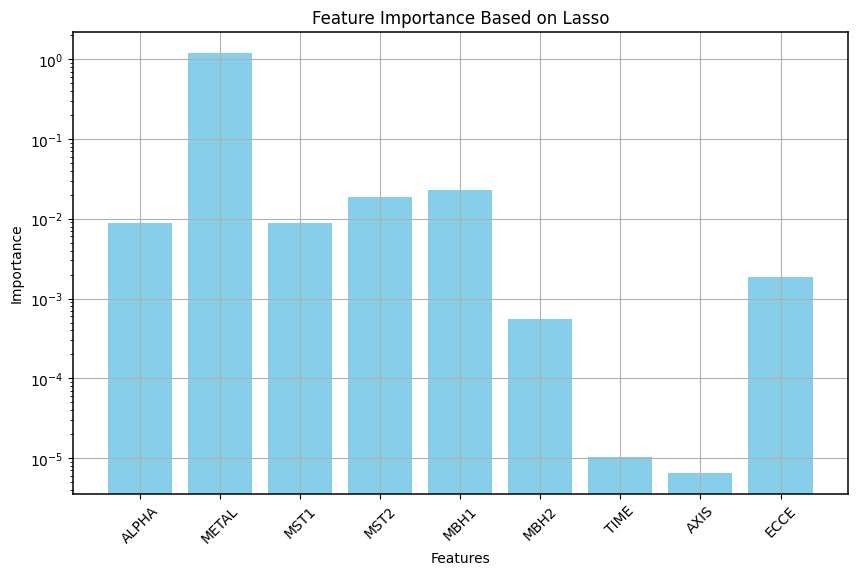

In [13]:
# plotting the Column Names and Importance of Columns.
#making_plot(X.columns, importances, "Feature Importance Based on Lasso", "Features", "Importance")
draw_plot(X.columns, importances_l, "Feature Importance Based on Lasso", "Features", "Importance", True) #log = true

#draw_plot(X.columns, importances, "Feature Importance Based on Lasso", "Features", "Importance", False) #log = false

# Permutation

The idea behind permutation feature importance is that, the feature importance is calculated by noticing the increase or decrease in error when we permute the values of a feature. If permuting the values causes a huge change in the error, it means the feature is important for our model. 

The best thing about this method is that it can be applied to every machine learning model. Its approach is model agnostic, which gives you a lot of freedom. There are no complex mathematical formulas behind it. The permutation feature importance is based on an algorithm that works as follows:
<br> 1. Calculate the mean squared error with the original values.
<br> 2. Shuffle the values for that features and make predictions.
<br> 3. Calculate the mean squared error with the shuffled values.
<br> 4. Compare the differences between them.
<br> 5. Reverse the shuffling to get the original data back. 
<br> 6. Redo steps 2-5 using the next attribute, until the importance for every feature is determined.
<br> 7. Sort the differences in descending order to get features with most to least importance.

This technique measures the contribution of a feature by measuring the changes in the model performance after randomly shuffling its values. This approach is straightforward but can be computationally intensive for large datasets. 

In our code, we used a scikit-learn function where feature importance is evaluated in a predictive model by the impact on the model’s performance (here, utilizing accuracy scoring) when the values of each feature are randomly shuffled. The <i>n_repeats</i> parameter specifies the number of times each feature’s values are randomly shuffled to assess its impact on the model’s performance. In our case, each feature will be permuted 30 times, and the model’s performance will be evaluated after each permutation, hence the aggregate calculation of the mean and standard deviation of the importance values. However, selecting the value of <i>n_repeats</i> has computational consequences as higher values can highlight precise and robust importance calculations but higher computational cost.

In [14]:
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance

def permutation_test():
    model = Ridge(alpha=1e-2).fit(X_train, y_train)
    model.score(X_test, y_test)

    r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)

    return r.importances_mean

In [15]:
#Calling the permutation method to get the feature importances
importances_p = permutation_test()

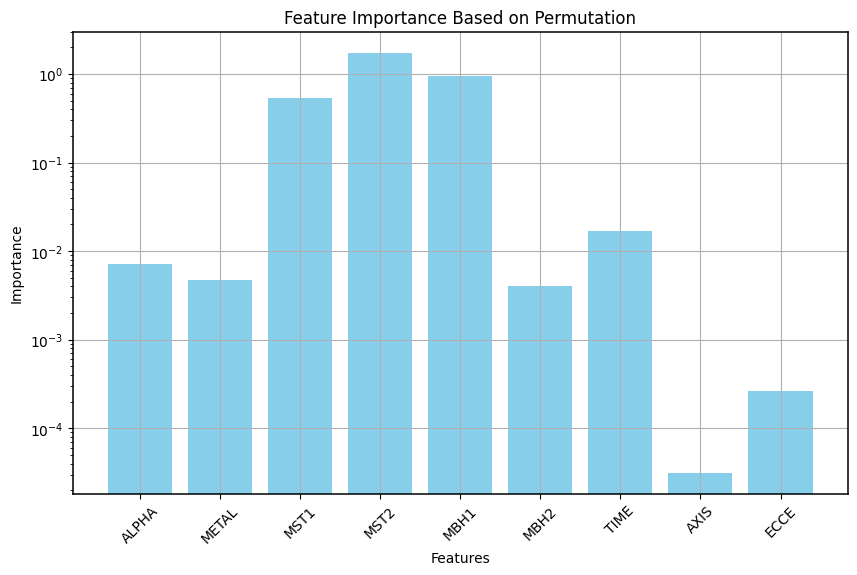

In [16]:
# plotting the Column Names and Importance of Columns.
#making_plot(X.columns, importances, "Feature Importance Based on Permutation", "Features", "Importance")
draw_plot(X.columns, importances_p, "Feature Importance Based on Permutation", "Features", "Importance", True) #log = true

#draw_plot(X.columns, importances, "Feature Importance Based on Permutation", "Features", "Importance", False) #log = false

# Single-Variable Prediction

Single-variable prediction is a method of feature importance that measures the performance of a model when only one feature is used to make predictions. 

This can be done by training a model using only one feature and comparing its performance to the performance of the model when all features are used. The feature that results in the highest performance when used alone is considered the most important.

It should be noted that the importance of a feature may depend on the context in which it is used – for example, a feature that is important in isolation may not be so important when considered in combination with other features.


Single-variable prediction entails training an ML model for each individual feature to understand how well the variable is able to predict the target value. It consists of building a model with the individual features, evaluating across respective metrics, and observing how significant each feature is to predicting the target. It provides simplicity and intuitiveness, however, this method doesn’t capture the intrinsic interactions that exist between features to create a combined impact on the model.

In [17]:
from sklearn.feature_selection import SelectKBest, f_regression

def SVP_test():
    # Applying SelectKBest with ANOVA F-value
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X, y)
    
    # Displaying scores for each feature
    #feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
    #print(feature_scores.sort_values(by='Score', ascending=False))
    
    return selector.scores_

In [18]:
#Calling the Single-Variable Prediction method to get the feature importances
importances_svp = SVP_test()

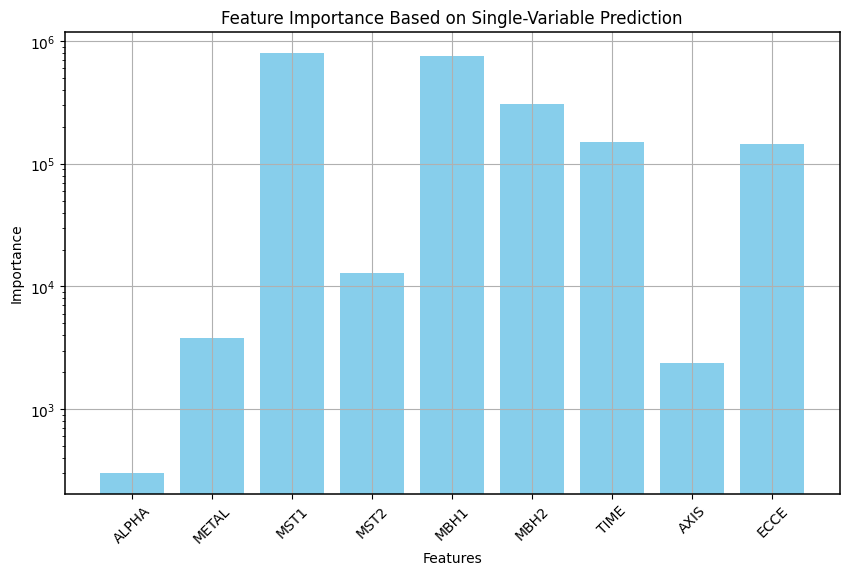

In [19]:
# plotting the Column Names and Importance of Columns.
#making_plot(X.columns, importances, "Feature Importance Based on Single-Variable Prediction", "Features", "Importance")
draw_plot(X.columns, importances_svp, "Feature Importance Based on Single-Variable Prediction", "Features", "Importance", True) #log = true

#draw_plot(X.columns, importances, "Feature Importance Based on Single-Variable Prediction", "Features", "Importance", False) #log = false

# Recursive Feature Elimination (RFE)

RFE is a feature selection method that iteratively evaluates the importance of features and removes the least important ones until the desired number remains. It uses the model’s internal feature importance measures to guide the elimination process.
<br> 1. Train the model on the full dataset.
<br> 2. Rank features based on their importance scores (in our aprocach these are obtained either from the coefficients of a linear regression).
<br> 3. Remove the least important feature(s) and retrain the model.
<br> 4. Repeat until a stopping criterion is met, such as reaching a desired number of features or observing a performance drop.

Importantly, in RFE, higher ranking values denote lower importance.

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def RFE_test():
    # Initialize the model (LinearRegression here, but you can use others)
    model = LinearRegression()
    
    # Applying RFE
    rfe = RFE(estimator=model, n_features_to_select=5)  # Change n_features_to_select as needed
    rfe.fit(X, y)
    
    # Displaying ranking of features
    #feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})
    #print(feature_ranking.sort_values(by='Ranking'))
    
    return rfe.ranking_

In [21]:
#Calling the permutation method to get the feature importances
ranking_rfe = RFE_test()

In [22]:
#importances

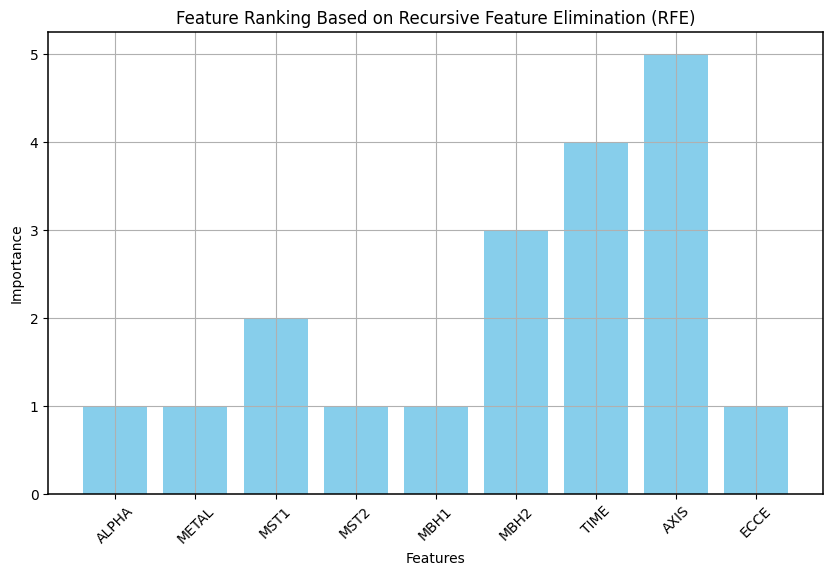

In [23]:
# plotting the Column Names and Importance of Columns.
#making_plot(X.columns, importances, "Feature Importance Based on Recursive Feature Elimination (RFE)", "Features", "Importance")
draw_plot(X.columns, ranking_rfe, "Feature Ranking Based on Recursive Feature Elimination (RFE)", "Features", "Importance", False) #log = true

#draw_plot(X.columns, importances, "Feature Importance Based on Recursive Feature Elimination (RFE)", "Features", "Importance", False) #log = false

# Principal Component Analysis(PCA)

PCA is a dimensionality reduction that identifies important relationships in our data, transforms the existing data based on these relationships, and then quantifies the importance of these relationships so we can keep the most important relationships and drop the others. To remember this definition, we can break it down into four steps:
<br>1. We identify the relationship among features through a Covariance Matrix.
<br>2. Through the linear transformation or eigendecomposition of the Covariance Matrix, we get eigenvectors and eigenvalues.
<br>3. Then we transform our data using Eigenvectors into principal components.
<br>4. Lastly, we quantify the importance of these relationships using Eigenvalues and keep the important principal components.

For example, below the first principal component (PC1) is mostly aligned with Time, which has the highest weight of 0.999 in absolute value. This does not imply that Time is the most imporant feature rather it means while re-calculating the dataset for PC1, Time has the largest impact. 

Because, Importantly, PCA is not a feature selection technique. Rather, it combines the features. Because each PC is a weighted additive combination of all the columns in the original dataset. However, the PCs are formed in such a way that the first Principal Component (PC1) explains more variance in original data compared to PC2. Likewise, PC2 explains more than PC3, and so on.

In [24]:
from sklearn.decomposition import PCA

def PCA_test():
    # Applying PCA
    pca = PCA(n_components=2)  # Adjust n_components as needed
    principal_components = pca.fit_transform(X)
    
    # Displaying explained variance ratio of each component
    explained_variance = pd.DataFrame({'Component': range(1, pca.n_components_ + 1), 'Explained Variance': pca.explained_variance_ratio_})
    print(explained_variance)

    component_weights = pca.components_
    #print("Component Weights:\n", component_weights)
    
    feature_weights_mapping = {}
    for i, component in enumerate(component_weights):
        component_feature_weights = zip(X.columns, component)
        feature_weights_mapping[f"Component {i+1}"] = component_feature_weights
        #sorted(component_feature_weights, key=lambda x: abs(x[1]), reverse=True)
    
    # Accessing feature names contributing to Component 1
    #print("Feature names contributing to Component 1:")
    feat1 = []
    wght1 = []
    for feature, weight in feature_weights_mapping["Component 1"]:
        feat1.append(feature)
        wght1.append(weight)
        #print(f"{feature}: {weight}")
    
    # Accessing feature names contributing to Component 2
    #print("Feature names contributing to Component 2:")
    feat2 = []
    wght2 = []
    for feature, weight in feature_weights_mapping["Component 2"]:
        feat2.append(feature)
        wght2.append(weight)
        #print(f"{feature}: {weight}")

    return feat1, wght1, feat2, wght2

In [25]:
#Calling the PCA method to get the features(as f1 and f2) and their corresponding importances(as weights w1 and w2)
# along the first and second principle componants (PCA1 & PCA2)

f1, w1, f2, w2 = PCA_test()

   Component  Explained Variance
0          1            0.991917
1          2            0.007993


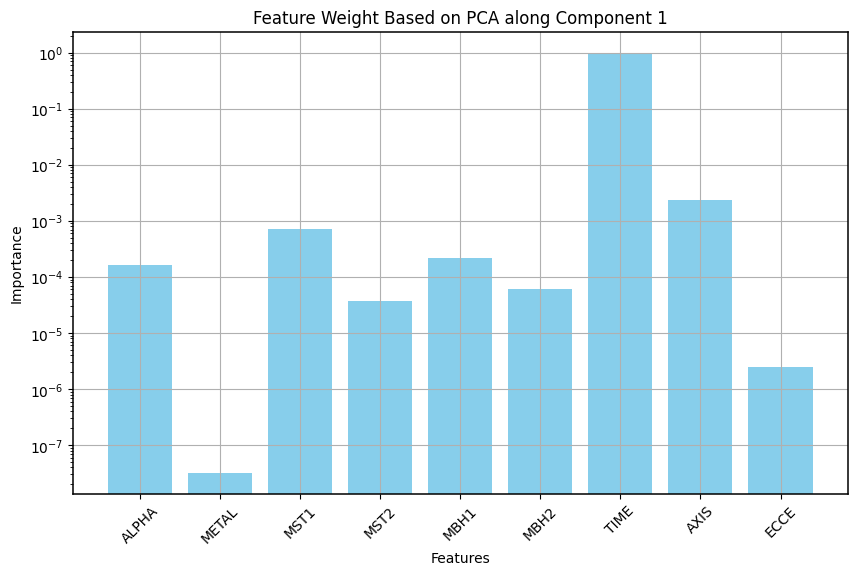

In [26]:
# plotting the Column Names and Importance of Columns.

#making_plot(f1, w1, "Feature Weight Based on PCA along Component 1", "Features", "Importance")
#making_plot(f2, w2, "Feature Weight Based on PCA along Component 2", "Features", "Importance")

draw_plot(f1, w1, "Feature Weight Based on PCA along Component 1", "Features", "Importance", True) #log = true

#draw_plot(f1, w1, "Feature Weight Based on PCA along Component 1", "Features", "Importance", False) #log = false

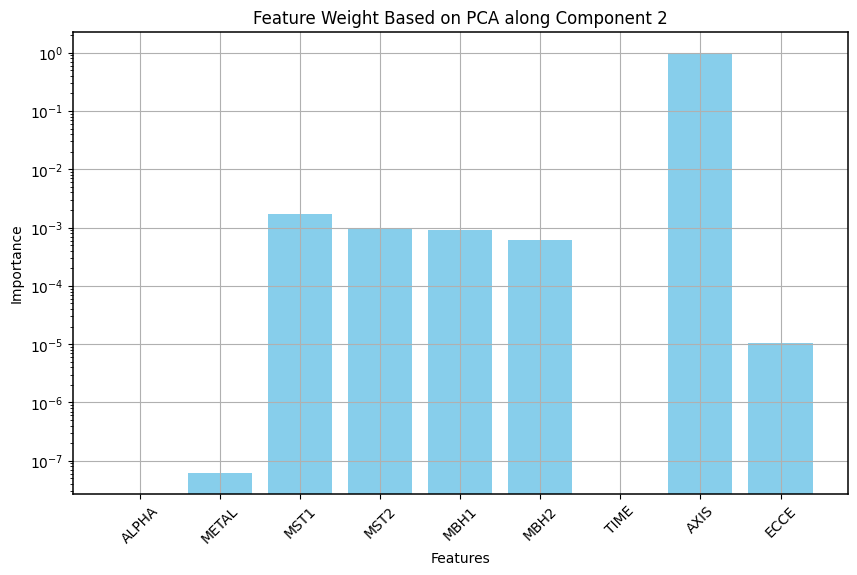

In [27]:
draw_plot(f2, w2, "Feature Weight Based on PCA along Component 2", "Features", "Importance", True) #log = true

#draw_plot(f2, w2, "Feature Weight Based on PCA along Component 2", "Features", "Importance", False) #log = false

# Extreme Gradient Boosting (XGBoost)

A benefit of using gradient boosting is that after the boosted trees are constructed, it is relatively straightforward to retrieve importance scores for each attribute.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

The comparison between the XGBoost classifier and Random Forest is that although both of these methods use tree-based learners, their architecture and algorithms are fundamentally different, which results in differences in performance and accuracy. Specifically, XGBoost uses thee 'boosting' technique whresas Random Forest uses the 'bagging' technique.

In [28]:
#pip install xgboost

In [35]:
from xgboost import XGBClassifier

def xgboost_test():
    model = XGBClassifier()
    model.fit(X_train, y_train)
    #importances = pd.DataFrame(data={
     #   'Attribute': X_train.columns,
      #  'Importance': model.feature_importances_
    #})
    return model.feature_importances_
    #importances = importances.sort_values(by='Importance', ascending=False)

ModuleNotFoundError: No module named 'xgboost'

In [31]:
#Calling the permutation method to get the feature importances
importances_xgb = xgboost_test()

NameError: name 'xgboost_test' is not defined

In [32]:
# plotting the Column Names and Importance of Columns.
#making_plot(X.columns, importances, "Feature Importance Based on XGB Classifier", "Features", "Importance")

draw_plot(X.columns, importances_xgb, "Feature Importance Based on XGB Classifier", "Features", "Importance", True) #log = true

#draw_plot(X.columns, importances, "Feature Importance Based on XGB Classifier", "Features", "Importance", False) #log = false

NameError: name 'importances_xgb' is not defined

---

### File manager
The following class automates the handling of files and directories: the model can be loaded regardless of whether it has been run before the loading. Each file has names and directories assigned to it. A '.save' method is also implemented to save models properly, minimizing the risk of overwriting.

In [ ]:
# to organize files
class DATA(object):
    def load(self):
        if (not self.is_loaded) and self.if_exist:
            self.data      = TRY_LOAD(self.path)
            self.is_loaded = True
        elif not self.if_exist:
            print("file '" + self.path + "' does not exist")
            #
        #####
        #
    #####
    #
    def __init__(self, dataset_ver, dir, model_name = ""):
        model_name      += model_name if model_name == "" else "_"
        self.dataset_ver = model_name + dataset_ver
        self.dir         = dir
        self.path        = self.dir + self.dataset_ver
        self.tmp         = TRY_LOAD(self.path)
        self.data        = None
        self.is_loaded   = False
        self.if_exist    = not isinstance(self.tmp, int)
        del self.tmp
        #
        self.load()
        #
    #####
    #
    def save(self, data):
        if not self.if_exist:
            SAVE(data, self.dir, self.dataset_ver)
            self.if_exist = True
        else:
            print("file '" + self.path + "' exists yet")
            #
        #####
        #
    #####
    #
#####

### Models manager
The 'MODEL' class properly manages models and dataframes. Each 'MODEL()' instance contains its data ('X' and 'Y'), and it is possible to specify the parameters of the models to run.

For the two algorithms from the 'sklearn' library, implemented in the 'RandomForestClassifier' and 'SVC' classes, a training process is performed: the dataframe is split into two sub-dataframes using the 'train_test_split' function from the 'sklearn' library. Specifically, the training set is set to be 80% of the original dataset, while the test set comprises the remaining 20%.

The test set is then used to evaluate the 'accuracy_score' achieved by the model, which is simply defined as the sum of both the true positives and true negatives, divided by the total number of predictions.

The weight of each feature is extracted using the appropriate attribute of the object. In SVM, both the training set and the test set are re-scaled before performing the algorithm, using the 'StandardScaler()' object. This process centers the data by subtracting the mean of the set and dividing by the standard deviation of the set. This re-scaling operation is necessary to prevent bias in the model, which can be affected by the scale of the data. With re-scaling, only the information that matters is preserved.

In [ ]:
# to organize models
class MODEL(object):
    def __init__(self, model_name, X, Y, all, if_fraction = False, crit = "gini", featrs = "sqrt", K = "linear", D = 3):
        self.model_name     = model_name
        self.X              = X
        self.columns        = self.X.columns
        self.Y              = Y
        self.crit           = crit
        self.featrs         = featrs
        self.K              = K
        self.D              = D
        self.if_all         = all
        self.model          = None
        self.accuracy_score = None
        self.weights        = None
        self.if_runned      = False
        if if_fraction:
            # chosing just 1/10 of the dataset
            self.X["CHOICE"] = np.random.randint(0, 10, self.X.shape[0])
            self.X           = self.X[self.X["CHOICE"] == 0]
            self.X           = self.X[self.X.columns[:-1]]
            self.Y           = self.Y.iloc[self.X.index]
            #
        #####
        #
        if not self.if_all:
            x_8, x_2, y_8, y_2 = train_test_split(self.X, self.Y, test_size = 0.2, random_state = RS_choice)
        else:
            x_8, x_2, y_8, y_2 = None, None, None, None
            #
        #####
        #
        self.X_train, self.X_test, self.Y_train, self.Y_test = x_8, x_2, y_8, y_2
        del x_8, x_2, y_8, y_2
        #
    #####
    #
    def run(self):
        if not self.if_runned:
            if self.if_all:
                X  = self.X
                Y  = self.Y
            else:
                X  = self.X_train
                Y  = self.Y_train
                Xt = self.X_test
                Yt = self.Y_test
                #
            #####
            #
            #
            if   self.model_name == model_name["RF"]:
                # feedback
                print("'" + model_name["RF"] + "' chosen")
                #
                # Random Forest
                model = return_RF_model(self.crit, self.featrs)
                #
                # running
                model.fit(X, Y)
                #
                # testing
                if not self.if_all:
                    Yp                  = model.predict(Xt)
                    self.accuracy_score = make_confusion_matrix(Yt, Yp)
                    #
                #####
                #
                # wheigts saving
                self.weights = pd.DataFrame(model.feature_importances_, self.columns).T
                #
                #
            elif self.model_name == model_name["SVM"]:
                # feedback
                print("'" + model_name["SVM"] + "' chosen")
                #
                # SVM
                model = return_SVM_model(self.K, self.D)
                #
                # scaling data
                scaler = StandardScaler()
                X      = scaler.fit_transform(X)
                #
                # running
                model.fit(X, Y)
                #
                # testing
                if not self.if_all:
                    Yp                  = model.predict(scaler.transform(Xt))
                    self.accuracy_score = make_confusion_matrix(Yt, Yp)
                    #
                #####
                #
                # wheigts saving
                if self.K == "linear":
                    self.weights = pd.DataFrame(model.coef_[0], self.columns).T
                else:
                    self.weights = permutation_importance(model, Xt, Yt, n_repeats = 10, random_state = RS_choice)
                    #
                #####
                #
                #
            elif self.model_name == model_name["th_nls"]:
                # feedback
                print("'" + model_name["th_nls"] + "' chosen")
                #
                # making df
                df         = X.copy()
                df["ISCE"] = Y
                #
                #th_analysis_for_b_classification
                model = return_th_nls_function()
                #
                # running
                model = model(df)
                del df
                #
                #
            elif self.model_name == model_name["gini"]:
                # feedback
                print("'" + model_name["gini"] + "' chosen")
                #
                # gini impurities
                model = Feature_Importances(X, Y)
                #
                # running
                model.evaluate_gini()
                #
                #
            else:
                # feedback
                print("'self.model_name' is INvalid")
                #
            #####
            #
            self.model     = model
            self.if_runned = True
            del self.X, self.Y
            del self.X_train, self.X_test
            del self.Y_train, self.Y_test
        else:
            # feedback
            print("model runned yet")
            #
        #####
        #
    #####
    #
#####

### Random Forest model
The Random Forest algorithm is designed to build a forest of different decision trees. Each tree is a diagram used to correctly classify an entry (row) of the dataset by performing a series of binary choices. At the end of the choice chain, the entry is classified as belonging or not to the common envelope type.

To choose the best intermediate node among all features, a numerical evaluation is computed, called the Gini impurity (more details can be found in the specific class). This value is calculated for different features in order to select:
1. the feature with which to start the tree (the root);
2. the threshold (of the chosen feature) to use for the binary choice.

After evaluating the root node, the dataset is split according to the binary choice of the root node, and another Gini impurity analysis is performed separately on each of the two subsets to find the next two nodes.

When a node can no longer be split without resorting to the remaining binary choice of interest, the leaf node represents whether the system is evolving through a common envelope, depending on the other physical parameters.

To prevent the risk of overfitting, instead of building a single decision tree, the algorithm finds 'n_estimators' trees (100 in the function) by randomly selecting from both different entries and different features. The final binary classification choice is then made by weighting the results from all the trees.

In [ ]:
# random forest
def return_RF_model(crit, featrs):
    model = RandomForestClassifier(n_estimators             = 100,     # The number of trees in the forest;
                                   criterion                = crit,    # The function to measure the quality of a split
                                                                       # {"gini", "entropy", "log_loss"};
                                   max_depth                = None,    # The maximum depth of the tree;
                                   min_samples_split        = 2,       # The minimum number of samples required to split an internal node;
                                   min_samples_leaf         = 1,       # The minimum number of samples required to be at a leaf node;
                                   min_weight_fraction_leaf = 0.0,     # The minimum weighted fraction of the sum total of weights
                                                                       # (of all the input samples) required to be at a leaf node;
                                   max_features             = featrs,  # The number of features to consider when looking for the best split
                                                                       # {"sqrt", "log2", None} | int
                                                                       # max_features = sqrt(n_features) | log2(n_features) | n_features;
                                   max_leaf_nodes           = None,    # If None then unlimited number of leaf nodes;
                                   min_impurity_decrease    = 0.0,     # If this split induces a decrease of the impurity >=
                                                                       # then that node will be splitted;
                                   bootstrap              = True,      # If False, the whole dataset is used to build each tree;
                                   oob_score              = False,     # If to use out-of-bag samples to estimate the generalization score;
                                   n_jobs                 = -1,        # The number of jobs to run in parallel
                                                                       # "-1" means using all processors;
                                   random_state           = RS_choice, # Used for reproducibility;
                                   verbose                = 2,         # Controls the verbosity when fitting and predicting;
                                   warm_start             = False,     # if True reuse solution of previous call to add more estimators;
                                   class_weight           = None,      # dict of Weights associated with features;
                                   ccp_alpha              = 0.0,       # The subtree with the largest cost complexity that is smaller
                                                                       # than this will be chosen;
                                   max_samples            = None,      # If bootstrap is True, it is the number of samples to draw from X;
                                   monotonic_cst          = None)      # If is None then no constraints are applied;
    return model
    #
#####

### Support Vector Machines
Support Vector Machines (SVM) is a model in which a binary classifier is run to classify a set of points. The classifier works by attempting to separate a set living in a hyperspace into two subsets using a hyperplane.

The splitting mechanism does not work in all situations, depending on the nature of the set; therefore, a way to generalize this process is to artificially increase the dimensionality of the dataset by adding new degrees of freedom that depend on the previous ones.

Increasing dimensionality is the method by which the classifier can separate a set of points belonging to two distinct categories with a hyperplane. The number of dimensions to add and the dependencies to use in order to optimize the efficiency of the computation depend on specific cases.

In this context, we use a 'linear' kernel, which means employing a hyperplane to separate the points.

In [ ]:
# support vector machines
def return_SVM_model(K = "linear", D = 3):
    model = SVC(C                       = 1.0,         # Regularization parameter: the strength is inversely proportional to C;
                kernel                  = K,           # The kernel type to be used
                                                       # {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'};
                degree                  = D,           # Degree of the polynomial kernel function ('poly');
                gamma                   = "scale",     # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
                                                       # {'scale', 'auto'};
                coef0                   = 0.0,         # Independent term in kernel function; significant in 'poly' and 'sigmoid';
                shrinking               = True,        # Whether to use the shrinking heuristic;
                probability             = False,       # Whether to enable probability estimates;
                tol                     = 0.001,       # Tolerance for stopping criterion;
                cache_size              = 200,         # The size of the kernel cache (in MB);
                class_weight            = None,        # Set the parameter C of class i to class_weight[i] * C;
                verbose                 = True,        # Controls the verbosity when fitting and predicting;
                max_iter                = -1,          # Hard limit on iterations within solver, or -1 for no limit;
                decision_function_shape = "ovr",       # The parameter is ignored for binary classification; 
                break_ties              = False,       # If true and number of classes > 2, will break ties (at high computational cost);
                random_state            = RS_choice)   # Used for reproducibility;
    return model
    #
#####

### Gini Impurities
The 'Feature_Importances' class is designed to evaluate the Gini impurities of each feature. To optimize computational power, the evaluation is performed on a randomly chosen subset (1/10) rather than the entire dataset.

First, the values of the chosen feature are sorted in ascending order. For each pair of adjacent values, the average is computed, and the following values are evaluated for each average:
1. the number of '**False**' entries with the chosen feature **less** than the average;
2. the number of '**True**' entries with the chosen feature **less** than the average;
3. the number of '**False**' entries with the chosen feature **more** than the average;
4. the number of '**True**' entries with the chosen feature **more** than the average.

Points 1 and 2 are summed together (resulting in '**D_m**') and used to normalize each of the two points. The results are then squared and both subtracted from one (resulting in '**leaf_m**'); the computation is performed again for points 3 and 4 (resulting in '**D_M**' and '**leaf_M**'). '**leaf_m**' and '**leaf_M**' are then used to calculate a weighted sum, where the two terms are: **D_m / (D_m + D_M)** and **D_M / (D_m + D_M)**.

When the Gini impurity is evaluated for each pair of values, the minimum is chosen, and the corresponding average becomes the threshold of the node in the tree-building process. This class is not intended to evaluate trees; rather, it focuses on determining the minimum Gini impurity and the corresponding threshold for each feature.

The lower the Gini impurity, the greater the role played by the corresponding feature in determining the behavior of the physical system.

In [ ]:
class Feature_Importances:
    def __init__(self, x, y):
        if not debugging:
            # select 1/10 of the dataset
            x["CHOICE"] = np.random.randint(0, 10, x.shape[0])
            x           = x[x["CHOICE"] == 0]
            x           = x[x.columns[:-1]]
            y           = y.iloc[x.index]
            #
        #####
        #
        self.x          = x
        self.y          = y
        self.x_columns  = list(x.columns)
        self.index      = x.index
        self.n_rows     = x.shape[0]
        self.n_columns  = x.shape[1]
        self.impurities = None
        #
    #####
    #
    def cellular_gini(self, index, column):
        if ((index % 5000) == 0): print(column, "progress: ", int((index / self.n_rows) * 1e6) / 1e4, "%")
        root_node = pd.DataFrame(np.zeros((3, 2)), index = ["True", "False", "Sums"], columns = ["<", ">"])
        #
        root_node.loc["True",  "<"] =    self.y[ :index].astype(int).sum()
        root_node.loc["False", "<"] = (~ self.y[ :index]).astype(int).sum()
        root_node.loc["True",  ">"] =    self.y[index: ].astype(int).sum()
        root_node.loc["False", ">"] = (~ self.y[index: ]).astype(int).sum()
        root_node.loc["Sums",  "<"] = root_node.sum(axis = 0)["<"]
        root_node.loc["Sums",  ">"] = root_node.sum(axis = 0)[">"]
        #
        D_m = root_node.loc["Sums",  "<"]
        D_M = root_node.loc["Sums",  ">"]
        D   = root_node.sum(axis = 1)["Sums"]
        #
        leaf_m   = 1 - ((root_node.loc["True",  "<"] / D_m) ** 2) - ((root_node.loc["False",  "<"] / D_m) ** 2)
        leaf_M   = 1 - ((root_node.loc["True",  ">"] / D_M) ** 2) - ((root_node.loc["False",  ">"] / D_M) ** 2)
        impurity = ((D_m / D) * leaf_m) + ((D_M / D) * leaf_M)
        #
        return impurity
        #
    #####
    #
    def evaluate_column(self, column):
        self.x = self.x.sort_values(by = column, ascending = True)
        self.y = self.y.loc[self.x.index]
        #
        gini_impurities = [self.cellular_gini(index, column) for index in list(range(self.n_rows))[1:]]
        MIN             = min(gini_impurities)
        index           = gini_impurities.index(MIN)
        th              = (self.x[column].iloc[index] + self.x[column].iloc[index + 1]) / 2
        #
        self.x = self.x.loc[self.index]
        self.y = self.y.loc[self.index]
        #
        impurity        = pd.DataFrame([[MIN, th]], index = [column], columns = ["gini", "th"])
        self.impurities = pd.concat([self.impurities, impurity], ignore_index = False)
        #
    #####
    #
    def evaluate_gini(self):
        _ = [self.evaluate_column(column) for column in self.x_columns]
        #
    #####
    #
#####
#
#

### Threshold Analysis for Binary Classification
The following function behaves similarly to the Gini impurity evaluation ('.evaluate_gini()' method). However, the implementation differs in how it finds the threshold: instead of examining all adjacent values, it performs a binary search among the values.

Additionally, the computed value is different; instead of calculating Gini impurities, the algorithm explicitly computes the fraction of prominent binary guesses. For each potential threshold, the function evaluates how many 'True' and 'False' entries belong to each part of the interval divided by the threshold. The subsequent evaluation aims to maximize heterogeneity in the distribution of boolean values among the intervals by adjusting the potential threshold.

The result of the 'th_analysis_for_b_classification()' function is the fraction of 'True' or 'False' in each interval and the corresponding threshold. The procedure is executed independently for each combination of ALPHA and METAL parameters.

The chosen feature with the smallest interval of maximizing thresholds across all ALPHA and METAL combinations should be considered the most effective, demonstrating both high predictive power and stability among all parameter combinations.

In [ ]:
# A threshold optimization algorithm for binary classification tasks
# 'threshold_analysis_for_binary_classification'
def return_th_nls_function():
    def th_analysis_for_b_classification(df_in):
        features = list(df_in.columns)[2:-1]
        #
        #
        def find_scale_in_base_2(range):
            scale = 0
            while (range / (2 ** scale)) > 1: scale += 1
            return scale + 2
            #
        #####
        #
        #
        def find_new_range(MIN, MAX, TH):
            average = (MIN + MAX) / 2
            if TH > average:
                new_MIN = average
                new_MAX = MAX
            else:
                new_MIN = MIN
                new_MAX = average
                #
            #####
            #
            return new_MIN, new_MAX
            #
        #####
        #
        #
        def evaluate_th(df, ft, TH, is_major, best, th_best):
            df["BOOL"]  = (df[ft] > TH) if is_major else (df[ft] < TH)
            df["IP"]    = ((df["BOOL"] & df["ISCE"]) | ((~ df["BOOL"]) & (~ df["ISCE"]))).astype(int)
            esit        = (df["IP"].sum() / df["IP"].size)
            if best     < esit:
                best    = esit
                th_best = TH
                #
            #####
            #
            return th_best, best
            #
        #####
        #
        #
        def find_best_th(df, ths, ft):
            best_1, th_best_1 = 0, 0
            best_2, th_best_2 = 0, 0
            best,   th_max    = 0, 0
            is_major          = True
            #
            for TH in ths:
                th_best_1, best_1 = evaluate_th(df, ft, TH, True,  best_1, th_best_1)
                th_best_2, best_2 = evaluate_th(df, ft, TH, False, best_2, th_best_2)
                #
            #####
            #
            if best_1 > best_2:
                best, th_max = best_1, th_best_1
            else:
                best, th_max = best_2, th_best_2
                is_major     = False
                #
            #####
            #
            return best, th_max, is_major
            #
        #####
        #
        #
        def find_best_points(df_tmp, ft):
            result = []
            for i in ALPHA:
                for j in METAL:
                    df       = df_tmp[(df_tmp["ALPHA"] == i) & (df_tmp["METAL"] == j)][[ft, "ISCE"]]
                    progress = ((int((((len(METAL) * ALPHA.index(i)) + METAL.index(j)) / (len(ALPHA) * len(METAL))) * 1000)) / 10)
                    print("feature: ", ft, " progress: ", progress, "%")
                    #
                    MIN      = df[ft].min()
                    MAX      = df[ft].max()
                    scale    = find_scale_in_base_2(MAX / MIN)
                    ths      = np.linspace(MIN, MAX, 100)
                    #
                    best, TH, is_major      = find_best_th(df, ths, ft)
                    for w in range(scale):
                        number_of_points    = int(50 + (50 * (w/scale)))
                        MIN, MAX            = find_new_range(MIN, MAX, TH)
                        ths                 = np.linspace(MIN, MAX, number_of_points)
                        best, TH, is_major  = find_best_th(df_tmp, ths, ft)
                        #
                    #####
                    #
                    result_row = [i, j, TH, is_major, best]
                    result    += [result_row]
                    del df
                    #
                #####
                #
            #####
            #
            result            = pd.DataFrame(np.array(result))
            result["feature"] = ft
            #
            return result
            #
        #####
        #
        result     = [find_best_points(df_in, feature) for feature in features]
        df         = pd.concat(result, ignore_index = True)
        df.columns = ["ALPHA", "METAL", "TH", "is_major", "PREDIC. [%]", "feature"]
        #
        return df
        #
    #####
    #
    return th_analysis_for_b_classification
    #
#####

### Working data, paths and models
The following code is designed to create instances of files and models and perform computations. If a computation has already been completed (meaning the corresponding file exists in the correct location), the model is simply loaded from the file; otherwise, it will be saved after execution.

In [ ]:
# DATA
#
X0, Y0, X1, Y1 = reading_all_datasets()
if debugging:
    X0N, Y0N, X1N, Y1N = pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([]), []
    for A in ALPHA:
        for M in METAL:
            X0N = pd.concat([X0N, X0[(X0["ALPHA"] == A) & (X0["METAL"] == M)].iloc[0:2]], ignore_index = False)
            X1N = pd.concat([X1N, X1[(X1["ALPHA"] == A) & (X1["METAL"] == M)].iloc[0:2]], ignore_index = False)
            #
    #########
    X0 = X0N
    X1 = X1N
    Y0 = Y0.iloc[X0N.index]
    Y1 = Y1.iloc[X1N.index]
    del X0N, X1N
    #
#####
#
# describing
# X0.describe().iloc[[1, 2, 3, 7]].T
# X1.describe().iloc[[1, 2, 3, 7]].T
#
#
#
# paths
#
#RF_all_ORIGIN             = DATA(dataset_version["ORIGIN"], dir["RF_all"])
#RF_all_DER_1              = DATA(dataset_version["DER_1"],  dir["RF_all"])
#RF_all_DER_2              = DATA(dataset_version["DER_2"],  dir["RF_all"])
#
RF_partial_ORIGIN         = DATA(dataset_version["ORIGIN"], dir["RF_partial"])           # output of the 'Random Forest Classifier'
RF_partial_DER_1          = DATA(dataset_version["DER_1"],  dir["RF_partial"])           # algorithm; for both datasets
#
#RF_all_th_analysis_ORIGIN = DATA(dataset_version["ORIGIN"], dir["RF_all_th_analysis"])   # output of the 'th_analysis_for_b_classification'
RF_all_th_analysis_DER_1  = DATA(dataset_version["DER_1"],  dir["RF_all_th_analysis"])   # function; for both datasets
#
#RF_all_impurities_ORIGIN  = DATA(dataset_version["ORIGIN"], dir["RF_all_impurities"])    # output of the '.evaluate_gini' method;
RF_all_impurities_DER_1   = DATA(dataset_version["DER_1"],  dir["RF_all_impurities"])    # for bath datasets
#
#SVM_all_ORIGIN            = DATA(dataset_version["ORIGIN"], dir["SVM_all"])
#SVM_all_DER_1             = DATA(dataset_version["DER_1"],  dir["SVM_all"])
#
SVM_partial_ORIGIN        = DATA(dataset_version["ORIGIN"], dir["SVM_partial"])            # output of the 'Support Vector Machines'
SVM_partial_DER_1         = DATA(dataset_version["DER_1"],  dir["SVM_partial"])            # algorithm; for both datasets
#
#
#
# create models
#
MOD_RF_partial_ORIGIN         = CREATE(RF_partial_ORIGIN,         MODEL(model_name["RF"],     X0, Y0, all = False))
MOD_RF_partial_DER_1          = CREATE(RF_partial_DER_1,          MODEL(model_name["RF"],     X1, Y1, all = False))
#
MOD_RF_all_th_analysis_DER_1  = CREATE(RF_all_th_analysis_DER_1,  MODEL(model_name["th_nls"], X1, Y1, all = True))
MOD_RF_all_impurities_DER_1   = CREATE(RF_all_impurities_DER_1,   MODEL(model_name["gini"],   X1, Y1, all = True))
#
MOD_SVM_partial_ORIGIN        = CREATE(SVM_partial_ORIGIN,        MODEL(model_name["SVM"],    X0, Y0, all = False, if_fraction = True))
MOD_SVM_partial_DER_1         = CREATE(SVM_partial_DER_1,         MODEL(model_name["SVM"],    X1, Y1, all = False, if_fraction = True))
#
#
#
# run if not runned yet
#
MOD_RF_partial_ORIGIN.run()
MOD_RF_partial_DER_1.run()
#
MOD_RF_all_th_analysis_DER_1.run()
MOD_RF_all_impurities_DER_1.run()
#
MOD_SVM_partial_ORIGIN.run()
MOD_SVM_partial_DER_1.run()
#
#
#
# save results
#
RF_partial_ORIGIN.save(MOD_RF_partial_ORIGIN)
RF_partial_DER_1.save(MOD_RF_partial_DER_1)
#
RF_all_th_analysis_DER_1.save(MOD_RF_all_th_analysis_DER_1)
RF_all_impurities_DER_1.save(MOD_RF_all_impurities_DER_1)
#
SVM_partial_ORIGIN.save(MOD_SVM_partial_ORIGIN)
SVM_partial_DER_1.save(MOD_SVM_partial_DER_1)
#
#
# free memory
del X0, Y0, X1, Y1

# Results loader
In this final section, the evaluated models are loaded, and the results are explicitly presented.

In [ ]:
model = MOD_RF_partial_ORIGIN
making_plot(model.weights.columns, model.weights.iloc[0],
            title  = "Random Forest performed on Original Dataset",
            xlabel = "Feature", ylabel = "Weight [more is better]",
            x = 6, y = 0.254, text = f"accuracy score: {(100 * model.accuracy_score):.2f}%")

In [ ]:
model = MOD_SVM_partial_ORIGIN
making_plot(model.weights.columns, np.abs(model.weights.iloc[0]),
            title  = "Support Vector Machines performed on Original Dataset",
            xlabel = "Feature", ylabel = "Weight in absolute value [more is better]",
            x = 6, y = 7.5, text = f"accuracy score: {(100 * model.accuracy_score):.2f}%")

In [ ]:
model = MOD_RF_partial_DER_1
making_plot(model.weights.columns, model.weights.iloc[0],
            title  = "Random Forest performed on Derived Dataset",
            xlabel = "Feature", ylabel = "Weight [more is better]",
            x = -0.35, y = 0.23, text = f"accuracy score: {(100 * model.accuracy_score):.2f}%")

In [ ]:
model = MOD_SVM_partial_DER_1
making_plot(model.weights.columns, np.abs(model.weights.iloc[0]),
            title  = "Support Vector Machines performed on Derived Dataset",
            xlabel = "Feature", ylabel = "Weight in absolute value [more is better]",
            x = -0.32, y = 8, text = f"accuracy score: {(100 * model.accuracy_score):.2f}%")

# Conclusion
Our analysis has revealed a predictable behavior: the physical system does not exhibit a linear dependence on the parameters. This is evident in the unsuccessful attempt of linear regression analysis to provide consistent results. Indeed, stellar physics is inherently nonlinear; stellar dynamics is influenced by thresholds at which behavior changes drastically.

In contrast, both Random Forest (RF) and Support Vector Machine (SVM) algorithms, which are useful for binary classification, have provided consistent results, indicating that stellar masses seem to play a major role in impacting mass transfer between stars. Additionally, the semi-major axes also appear to play an important role. Independent confirmations support this evidence, as demonstrated by the two algorithms implemented for Threshold Analysis and Gini Impurity computations.

An hypothesis of combined features is then formulated among those that make physical sense, carefully selecting the most prominent features. The number of derived features and the specific combinations are chosen to preserve all the information coming from the masses and the semi-major axes, without introducing any redundancy (maintaining the same number of derived features relative to the original ones used for derivation).

Among the derived features, the ratio between stellar masses (the smaller mass divided by the larger mass) seems to play the most significant role in the binary dynamics.